# Computer Vision with Model Caching

<table align="left">
    <td>
        <a href="https://colab.research.google.com/github/dreoporto/ptmlib/blob/main/ptmlib/notebooks/Computer-Vision-with-Model-Caching.ipynb">
            <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
        </a>
    </td>
</table>    

This notebook demonstrates using the PTMLib `model_tools.load_or_fit_model()` function to train and save a Computer Vision model.

This example was originally derived from the "DeepLearning.AI TensorFlow Developer" course notebook at https://github.com/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%204%20-%20Lesson%202%20-%20Notebook.ipynb

It has been enhanced to include:

- examples of PTMLib usage
- a dropout layer
- `validation_split` usage
- early stopping using a callback function

## Setup

### Import common libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Import PTMLib

In [2]:
# UNCOMMENT pip install BELOW IF USING A REMOTE ENVIRONMENT LIKE GOOGLE COLAB
# !pip install --no-index -f https://github.com/dreoporto/ptmlib/releases ptmlib

from ptmlib.time import Stopwatch, AlertSounds
import ptmlib.model_tools as modt

### Check Setup

In [3]:
print('TF VERSION:', tf.__version__)
print('KERAS VERSION:', keras.__version__)

TF VERSION: 2.7.0
KERAS VERSION: 2.7.0


## Setup PTMLib Timers

Use `Stopwatch` to alert you when work completes, including the entire notebook.

In [4]:
main_stopwatch = Stopwatch()
main_stopwatch.start()

Start Time: Fri Mar  4 07:32:10 2022


## Get MNIST Data

In [5]:
mnist = keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

### Check some sample data to verify

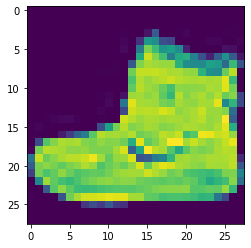

In [6]:
np.set_printoptions(linewidth=200)
plt.imshow(training_images[0])
plt.show()

In [7]:
print(training_labels[0])

9


### Normalize the image data

Normalize image data to values between 0 and 1

In [8]:
training_images = training_images / 255.0
test_images = test_images / 255.0

## Create the Keras model

### Setup Hyperparameters 1

In [9]:
hp_dropout = 0.2

### Create a Sequential model using Keras

In [10]:
# I <3 Keras

model = keras.models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dropout(hp_dropout),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dense(10, activation=tf.nn.softmax)
])

In [11]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Create an Early Callback function

Avoid excessive training by setting an accuracy target

In [13]:
class MyCallback(keras.callbacks.Callback):

    def __init__(self, target):
        super().__init__()
        self.target = target

    def on_epoch_end(self, _, logs=None):

        if logs is None:
            logs = {}
        if logs.get("accuracy") > self.target:
            print(f"\nReached {self.target * 100}% accuracy so cancelling training!")
            self.model.stop_training = True

## Train your model, with caching

### Setup Hyperparameters 2

In [14]:
hp_epochs = 50
hp_target = 0.91
hp_validation_split = 0.2

### Create a `fit` lambda function

Create a lambda function that will be called to fit your model

In [15]:
fit_model_function_with_callback = lambda my_model, x, y, validation_data, epochs: my_model.fit(
        x, y, validation_data, epochs=epochs, callbacks=[early_callback], validation_split=hp_validation_split)

### Train your model

If you run this notebook a second time, it will load the model and charts from the saved files.  No need to worry about shutting down Jupyter, or rebooting your machine (i.e. patches) !

Start Time: Fri Mar  4 07:32:11 2022
Epoch 1/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5236 - accuracy: 0.8091 - val_loss: 0.4093 - val_accuracy: 0.8467
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4076 - accuracy: 0.8514 - val_loss: 0.3741 - val_accuracy: 0.8627
Epoch 3/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3705 - accuracy: 0.8623 - val_loss: 0.3691 - val_accuracy: 0.8604
Epoch 4/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3471 - accuracy: 0.8712 - val_loss: 0.3385 - val_accuracy: 0.8754
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3337 - accuracy: 0.8747 - val_loss: 0.3332 - val_accuracy: 0.8802
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3168 - accuracy: 0.8813 - val_loss: 0.3185 - val_accuracy: 0.8820
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3053 - accuracy: 0.88

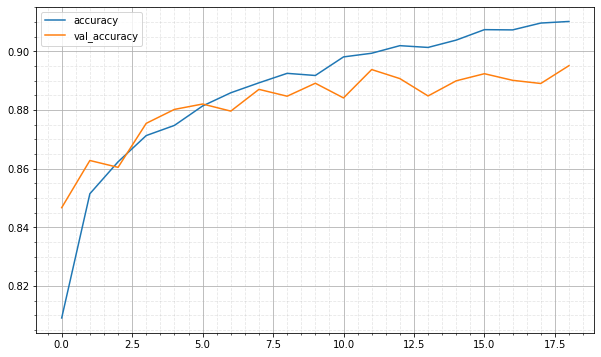

Saved image: loss-computer_vision_1.png


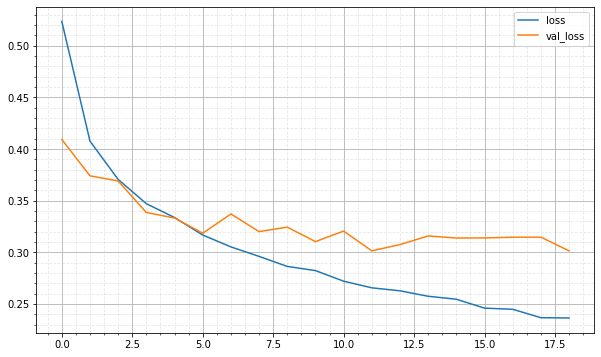

In [16]:
model_file_name = "computer_vision_1"
early_callback = MyCallback(target=hp_target)

model, history = modt.load_or_fit_model(model, model_file_name, x=training_images, y=training_labels, 
                                        epochs=hp_epochs, fit_model_function=fit_model_function_with_callback,
                                        metrics=["accuracy"])

## Evaluate your model

In [17]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.3260 - accuracy: 0.8897


[0.3260378837585449, 0.8896999955177307]

In [18]:
classifications = model.predict(test_images)

In [19]:
print(classifications[0])
print(test_labels[0])
print(max(classifications[0]))

[1.5205982e-08 1.7621725e-12 9.5039032e-10 4.1722658e-12 2.3409125e-11 9.4039806e-06 1.5102266e-09 2.1716191e-03 1.0427006e-10 9.9781895e-01]
9
0.99781895


## Simulate using a Cached Model

Run this function again to show what happens if you restart this notebook (ex: using *Kernel > Restart & Run All* in Jupyter)

Loading existing model file: computer_vision_1.h5


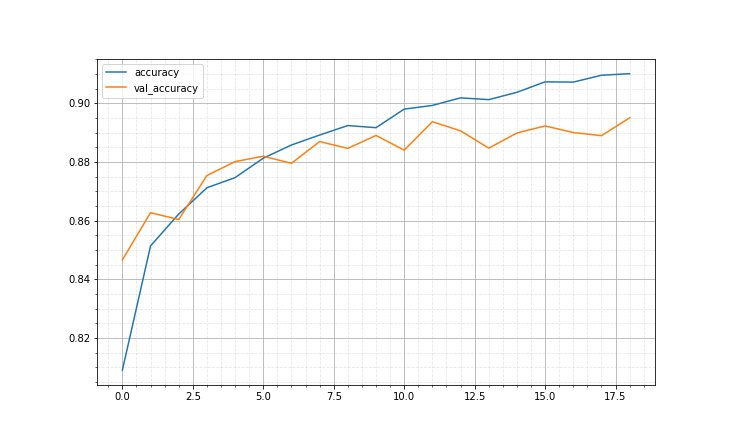

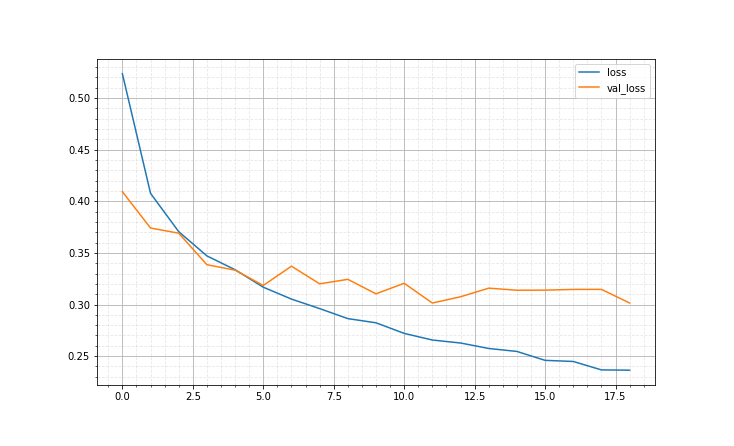

In [20]:
model, history = modt.load_or_fit_model(model, model_file_name, x=training_images, y=training_labels, 
                                        epochs=hp_epochs, fit_model_function=fit_model_function_with_callback,
                                        metrics=["accuracy"])

## Removing Cached Files

To run `load_or_fit_model` from scratch, without using the saved model and images, simply delete the following files, each of which contains *computer_vision_1* in the file name.  This was set using the `model_file_name` variable.

- computer_vision_1.h5
- accuracy-computer_vision_1.png
- loss-computer_vision_1.png

This is especially important if you are still adjusting your model layers or hyperparameters for model optimization.

You can also change the value of the `model_file_name` variable if you wish to save the results from multiple runs.  This is useful when comparing performance graphs.

In [21]:
# ALL DONE!

main_stopwatch.stop(sound_path=AlertSounds.DORE)

End Time:   Fri Mar  4 07:33:55 2022
Elapsed seconds: 104.4642 (1.74 minutes)
